In [2]:
!pip install redis
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 4.1 MB/s eta 0:00:00


In [13]:
import os
import redis
from redis.commands.search.field import VectorField, TagField
from redis.commands.search.query import Query
from deepface import DeepFace
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

Initializing Redis Client

In [14]:
r = redis.Redis(
    host = "redis-19025.c44.us-east-1-2.ec2.cloud.redislabs.com",
    port = 19025,
    password = "<password>",
    ssl = False,
)

r.ping()

True

Vector Embeddings - utilize the deepface library for Python to represent facial images as vector embeddings

In [15]:
embeddings = []

img_path = "/content/img1.jpeg"
embedding = DeepFace.represent(
                img_path=img_path,
                model_name="Facenet",
                detector_backend="mtcnn",
            )[0]["embedding"]
embeddings.append((img_path, embedding))

# Print the count of filenames
# print("Total filenames:", len(filenames))
print("Total embeddings:", len(embeddings))
# Print the embeddings
for embedding in embeddings:
  print(embedding)

1/1 [==============================] - 0s 40ms/step
Total embeddings: 1
('/content/img1.jpeg', [0.4467284381389618, 0.7149038314819336, 2.0348715782165527, -1.332535982131958, 0.7388046979904175, -0.17174702882766724, 1.7341407537460327, 0.7952598333358765, 1.5410672426223755, 0.9664729833602905, -1.0994577407836914, -0.19607074558734894, -1.2602185010910034, 0.2035820186138153, -1.841813564300537, 0.10480555891990662, -1.5440400838851929, -0.4721100330352783, 0.9749399423599243, -0.9259061813354492, 1.2175158262252808, -1.0712347030639648, -0.4717021882534027, -1.3506016731262207, -2.0928940773010254, 2.305877685546875, -0.5509076118469238, -0.6350110769271851, -1.0313876867294312, 1.1269623041152954, -0.08743885159492493, 0.9980886578559875, 0.6410297155380249, -1.5859794616699219, 0.6164854764938354, -0.8041358590126038, -1.4908337593078613, 0.5197127461433411, 1.4645259380340576, 0.5268020629882812, -1.0819640159606934, -0.20994845032691956, -1.0133047103881836, -0.0364128388464450

Storing Embeddings In Redis

In [24]:
pipeline = r.pipeline(transaction=False)
for img_path, embedding in tqdm(embeddings):
  key = img_path.split("/")[-1]
  value = np.array(embedding).astype(np.float32).tobytes()
  #pipeline.hset(key, mapping = {"embedding": value})

#pipeline_results = pipeline.execute()

100%|██████████| 1/1 [00:00<00:00, 5171.77it/s]


Create Index in Redis - HNSW - Hierarchical Navigable Small World algorithm

In [25]:
r.ft().create_index(
    [
        VectorField(
            "embedding",
            "HNSW",
            {
                "TYPE": "FLOAT32",
                "DIM": 128,
                "DISTANCE_METRIC": "L2",
            },
        )
    ]
)

b'OK'

Query Vector

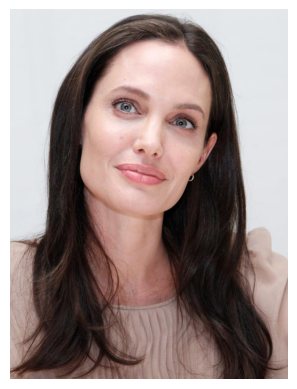

In [33]:
target_path = "/content/img11.jpeg"

target_img = cv2.imread(target_path)
plt.imshow(target_img[:,:,::-1])
plt.axis("off")
plt.show()

In [34]:
target_embedding = DeepFace.represent(
    img_path=target_path,
    model_name="Facenet",
    detector_backend="mtcnn"
)[0]["embedding"]

1/1 [==============================] - 0s 49ms/step


In [35]:
query_vector = np.array(target_embedding).astype(np.float32).tobytes()

Query

In [36]:
k = 3
base_query = f"*=>[KNN {k} @embedding $query_vector AS distance]"
query = Query(base_query).return_fields("distance").sort_by("distance").dialect(2)
results = r.ft().search(query, query_params={"query_vector": query_vector})

In [37]:
for idx, result in enumerate(results.docs):
    print(
        f"{idx + 1}th nearest neighbor is {result.id} with distance {result.distance}"
    )

    img = cv2.imread(f"deepface/tests/dataset/{result.id}")
    plt.imshow(img[:, :, ::-1])
    plt.axis("off")
    plt.show()

    print("---------------------")